# Exploratory Data Analysis (EDA)

In [1202]:
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Set display options to show all columns
pd.set_option('display.max_columns', None)

## Load data

In [1203]:
# Load weather data
conn_weather = sqlite3.connect('data/weather.db')
query = 'SELECT * FROM weather'
weather_df= pd.read_sql_query(query, conn_weather)

conn_weather.close()


In [1204]:
# Load air quality data
conn_air = sqlite3.connect('data/air_quality.db')
query = 'SELECT * FROM air_quality'
air_df = pd.read_sql_query(query, conn_air)

conn_air.close()

## inspect data

In [1205]:
weather_df.head()

,data_ref,date,Daily Rainfall Total (mm),Highest 30 Min Rainfall (mm),Highest 60 Min Rainfall (mm),Highest 120 Min Rainfall (mm),Min Temperature (deg C),Maximum Temperature (deg C),Min Wind Speed (km/h),Max Wind Speed (km/h),Sunshine Duration (hrs),Cloud Cover (%),Wet Bulb Temperature (deg F),Relative Humidity (%),Air Pressure (hPa),Dew Point Category,Wind Direction,Daily Solar Panel Efficiency
0,4d4d20c2-0167-4bc2-a62c-4df6e11fb2ea,01/04/2014,-,2,2,2,28.4,32.4,7.5,25.9,8.07,18.0,-59.3,100.0,1006,VH,W,High
1,c9d3c825-fd94-4e61-a4bc-2cf0f2208de0,02/04/2014,0,0,0,--,28.8,32.6,--,33.1,7.57,23.0,59.2,100.0,1005,Very High,S,Medium
2,6d445ffb-d4c2-4f94-a27e-224fabe46d10,03/04/2014,0,0,0,0,29.3,--,--,43.2,6.72,16.0,59.7,98.5,1005,Low,E,Medium
3,7a404c50-710f-451a-9a42-a66bb783a3d0,04/04/2014,0,0,0,0,28.6,32.4,7.4,33.1,7.55,20.0,59.1,100.0,1011,Very High,W,Medium
4,0d3194a7-ad1a-456e-9bf8-b1bae730977b,05/04/2014,23.4,15.2,17.2,17.4,26.4,28,5.4,28.1,5.27,74.0,58.9,100.0,1012,Very High,east,Low


In [1206]:
weather_df.describe()

,Sunshine Duration (hrs),Cloud Cover (%),Wet Bulb Temperature (deg F),Relative Humidity (%),Air Pressure (hPa)
count,3501.000000,3501.000000,3517.000000,3517.000000,3517.000000
mean,7.018320,28.682376,52.946062,97.366761,1008.668467
std,1.389904,20.788299,25.842174,5.043705,3.513724
min,0.000000,2.000000,-60.700000,68.600000,998.000000
25%,6.710000,17.000000,58.400000,96.700000,1006.000000
50%,7.400000,22.000000,58.900000,100.000000,1009.000000
75%,7.840000,30.000000,59.400000,100.000000,1011.000000
max,9.150000,100.000000,61.800000,100.000000,1020.000000


From the statistics, I've noticed that 2 features have negative values and are most likely erroneous:
1. Max Wind Speed (km/h) --> inherently a non negative quantity
2. Wet Bulb Temperature (deg C) --> extremely low or negative values are unusual and most likely errors.

In [1207]:
# Check for negative values in the numeric columns
numeric_columns = merged_df.select_dtypes(include=['number'])
negative_values = (numeric_columns < 0)

# Columns with negative values
columns_with_negatives = negative_values.any(axis=0)
negative_columns = columns_with_negatives[columns_with_negatives].index.tolist()

# Print the count of negative values in each column
for column in negative_columns:
    negative_count = merged_df[merged_df[column] < 0][column].count()
    print(f"Count of negative values in column '{column}': {negative_count}")


Count of negative values in column 'Wet Bulb Temperature (deg C)': 158


I will treat them as null values and replace with mean later on

In [1208]:
air_df.head()

,data_ref,date,pm25_north,pm25_south,pm25_east,pm25_west,pm25_central,psi_north,psi_south,psi_east,psi_west,psi_central
0,4d4d20c2-0167-4bc2-a62c-4df6e11fb2ea,01/04/2014,20,16,18,23,19,58,56,57,66,59
1,c9d3c825-fd94-4e61-a4bc-2cf0f2208de0,02/04/2014,18,14,-,22,16,57,53,54,61,56
2,6d445ffb-d4c2-4f94-a27e-224fabe46d10,03/04/2014,12,12,10,14,10,55,53,52,59,54
3,7a404c50-710f-451a-9a42-a66bb783a3d0,04/04/2014,--,-,24,19,25,58,57,55,-,56
4,0d3194a7-ad1a-456e-9bf8-b1bae730977b,05/04/2014,18,19,21,13,17,64,64,66,-,66


1. both dataset contains '-' and '--' values for numeric features
2. since both dataset has the feature 'date', I am going to merge the 2 datasets 
using 'date' feature. This is to create a more comprehensive dataset that includes all 
relevant feature and generate more accurate models.
3. I will convert 'web bulb temperature (deg F)' to deg C later on to ensure consistency

In [1209]:
air_df.describe()

,data_ref,date,pm25_north,pm25_south,pm25_east,pm25_west,pm25_central,psi_north,psi_south,psi_east,psi_west,psi_central
count,3875,3875,3836,3836,3836,3836,3836,3836,3836,3836,3836,3836
unique,3197,3197,74,86,76,85,68,112,113,108,117,105
top,a5f11eb5-41b1-4c1c-bae5-9d536ee2e58c,13/09/2014,11,10,9,8,10,52,52,52,52,53
freq,5,5,308,290,313,318,322,261,236,260,208,224


PM2.5 are relatively stable across all regions. \
PSI are relatively stable across all regions.

In [1210]:
print("dimension of air_df: " + str(air_df.shape))
print("dimension of weather_df: " + str(weather_df.shape))

dimension of air_df: (3875, 12)
dimension of weather_df: (3517, 18)


number of records is 3517 for weather dataset and 3875 for air dataset. 
It might be hard to merge the datasets later on. 

In [1211]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3517 entries, 0 to 3516
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   data_ref                       3517 non-null   object 
 1   date                           3517 non-null   object 
 2   Daily Rainfall Total (mm)      3517 non-null   object 
 3   Highest 30 Min Rainfall (mm)   3517 non-null   object 
 4   Highest 60 Min Rainfall (mm)   3517 non-null   object 
 5   Highest 120 Min Rainfall (mm)  3517 non-null   object 
 6   Min Temperature (deg C)        3517 non-null   object 
 7   Maximum Temperature (deg C)    3517 non-null   object 
 8   Min Wind Speed (km/h)          3517 non-null   object 
 9   Max Wind Speed (km/h)          3502 non-null   object 
 10  Sunshine Duration (hrs)        3501 non-null   float64
 11  Cloud Cover (%)                3501 non-null   float64
 12  Wet Bulb Temperature (deg F)   3517 non-null   f

In [1212]:
air_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3875 entries, 0 to 3874
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   data_ref      3875 non-null   object
 1   date          3875 non-null   object
 2   pm25_north    3836 non-null   object
 3   pm25_south    3836 non-null   object
 4   pm25_east     3836 non-null   object
 5   pm25_west     3836 non-null   object
 6   pm25_central  3836 non-null   object
 7   psi_north     3836 non-null   object
 8   psi_south     3836 non-null   object
 9   psi_east      3836 non-null   object
 10  psi_west      3836 non-null   object
 11  psi_central   3836 non-null   object
dtypes: object(12)
memory usage: 363.4+ KB


## Cleaning data

### 1. converting dtype
Some features in weather dataset and all features in air_quality dataset has \
object dtype when it is numeric. So i choose to convert it to numeric dtype for \
accurate data analysis. 

In [1213]:
# Define columns to convert to numeric in air data
air_numeric_columns = [
    'pm25_north', 'pm25_south', 'pm25_east', 'pm25_west', 'pm25_central',
    'psi_north', 'psi_south', 'psi_east', 'psi_west', 'psi_central'
]
    
# Convert columns to numeric
for column in air_numeric_columns:
    air_df[column] = pd.to_numeric(air_df[column], errors='coerce')

In [1214]:
# Define columns to convert to numeric in weather data
weather_numeric_columns = [
    'Daily Rainfall Total (mm)',
    'Highest 30 Min Rainfall (mm)',
    'Highest 60 Min Rainfall (mm)',
    'Highest 120 Min Rainfall (mm)',
    'Min Temperature (deg C)',
    'Maximum Temperature (deg C)',
    'Min Wind Speed (km/h)',
    'Max Wind Speed (km/h)'
]

# Convert specified columns to numeric in weather data
for column in weather_numeric_columns:
    weather_df[column] = pd.to_numeric(weather_df[column], errors='coerce')

Converting Wet bulb temperature from deg F to deg C

In [1215]:
# Convert Wet Bulb Temperature from Fahrenheit to Celsius
weather_df['Wet Bulb Temperature (deg C)'] = (weather_df['Wet Bulb Temperature (deg F)'] - 32) * 5.0/9.0

# Drop the original Fahrenheit column if no longer needed
weather_df = weather_df.drop(columns=['Wet Bulb Temperature (deg F)'])

In [1216]:
air_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3875 entries, 0 to 3874
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   data_ref      3875 non-null   object 
 1   date          3875 non-null   object 
 2   pm25_north    3462 non-null   float64
 3   pm25_south    3461 non-null   float64
 4   pm25_east     3461 non-null   float64
 5   pm25_west     3463 non-null   float64
 6   pm25_central  3467 non-null   float64
 7   psi_north     3480 non-null   float64
 8   psi_south     3471 non-null   float64
 9   psi_east      3458 non-null   float64
 10  psi_west      3473 non-null   float64
 11  psi_central   3464 non-null   float64
dtypes: float64(10), object(2)
memory usage: 363.4+ KB


In [1217]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3517 entries, 0 to 3516
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   data_ref                       3517 non-null   object 
 1   date                           3517 non-null   object 
 2   Daily Rainfall Total (mm)      3176 non-null   float64
 3   Highest 30 Min Rainfall (mm)   3156 non-null   float64
 4   Highest 60 Min Rainfall (mm)   3155 non-null   float64
 5   Highest 120 Min Rainfall (mm)  3167 non-null   float64
 6   Min Temperature (deg C)        3179 non-null   float64
 7   Maximum Temperature (deg C)    3171 non-null   float64
 8   Min Wind Speed (km/h)          3170 non-null   float64
 9   Max Wind Speed (km/h)          3147 non-null   float64
 10  Sunshine Duration (hrs)        3501 non-null   float64
 11  Cloud Cover (%)                3501 non-null   float64
 12  Relative Humidity (%)          3517 non-null   f

### 2. Remove duplicates

In [1218]:
print("number of duplicates in weather_df: " + str(weather_df.duplicated().sum()))
print("number of duplicates in air_df: " + str(air_df.duplicated().sum()))

number of duplicates in weather_df: 320
number of duplicates in air_df: 639


In [1219]:
weather_df = weather_df.drop_duplicates()
air_df = air_df.drop_duplicates()

I am going to merge the two datasets using the 'date' feature, 
so I would want to clean up the 'date' duplicates 
so there are lesser issues later on

In [1220]:
print("number of records with same date in weather_df: " + str(weather_df.duplicated('date').sum()))
print("number of records with same date in air_df: " + str(air_df.duplicated('date').sum()))

number of records with same date in weather_df: 0
number of records with same date in air_df: 39


Since there are only 39 date duplicates in air_df, I will just remove it.

In [1221]:
air_df = air_df.drop_duplicates('date')

In [1222]:
print("dimension of air_df: " + str(air_df.shape))
print("dimension of weather_df: " + str(weather_df.shape))

dimension of air_df: (3197, 12)
dimension of weather_df: (3197, 18)


After removing duplicates, there are equal number of records in both dataset. \
It will be easier to merge the datasets. 

### 3. Handling missing values

- replace non numeric values of numeric features to null
- replace negative values of the 2 features in weather_df to null
- replace the negative values with mean

In [1223]:
air_df.replace(['-', '--'], np.nan, inplace=True)
weather_df.replace(['-', '--'], np.nan, inplace=True)

In [1224]:
weather_df[['Wet Bulb Temperature (deg C)', 'Max Wind Speed (km/h)']] = \
weather_df[['Wet Bulb Temperature (deg C)', 'Max Wind Speed (km/h)']].map(lambda x: np.nan if x < 0 else x)

In [1225]:
weather_df.isnull().sum()

data_ref                           0
date                               0
Daily Rainfall Total (mm)        312
Highest 30 Min Rainfall (mm)     318
Highest 60 Min Rainfall (mm)     321
Highest 120 Min Rainfall (mm)    316
Min Temperature (deg C)          314
Maximum Temperature (deg C)      314
Min Wind Speed (km/h)            319
Max Wind Speed (km/h)            450
Sunshine Duration (hrs)           13
Cloud Cover (%)                   13
Relative Humidity (%)              0
Air Pressure (hPa)                 0
Dew Point Category                 0
Wind Direction                     0
Daily Solar Panel Efficiency       0
Wet Bulb Temperature (deg C)     158
dtype: int64

In [1226]:
air_df.isnull().sum()

data_ref          0
date              0
pm25_north      345
pm25_south      349
pm25_east       344
pm25_west       347
pm25_central    348
psi_north       310
psi_south       307
psi_east        312
psi_west        310
psi_central     316
dtype: int64

Each features with missing values are :
1. float dtype
2. has around 10% missing values

I decided to replace the missing values with mean value for each feature.

In [1227]:
# replace missing values in weather_df
weather_float_cols = weather_df.select_dtypes(include=['float64']).columns
weather_df[weather_float_cols] = weather_df[weather_float_cols].fillna(weather_df[weather_float_cols].mean())

In [1228]:
# replace missing values in air_df
air_float_cols = air_df.select_dtypes(include=['float64']).columns
air_df[air_float_cols] = air_df[air_float_cols].fillna(air_df[air_float_cols].mean())

### 4. Merge datasets

convert 'date' feature to pandas datetime object, then outer join based on 'date'.

In [1229]:
# Convert date columns to pandas datetime object
weather_df['date'] = pd.to_datetime(weather_df['date'], format='%d/%m/%Y')
air_df['date'] = pd.to_datetime(air_df['date'], format='%d/%m/%Y')


In [1230]:
# Merge the datasets on the date column using an outer join
merged_df = pd.merge(weather_df, air_df, on='date', how='outer')

In [1231]:
print(pd.DataFrame({
    'Missing Values': merged_df.isnull().sum(),
    'Duplicated Values': merged_df.duplicated().sum()
}))

                               Missing Values  Duplicated Values
data_ref_x                                  0                  0
date                                        0                  0
Daily Rainfall Total (mm)                   0                  0
Highest 30 Min Rainfall (mm)                0                  0
Highest 60 Min Rainfall (mm)                0                  0
Highest 120 Min Rainfall (mm)               0                  0
Min Temperature (deg C)                     0                  0
Maximum Temperature (deg C)                 0                  0
Min Wind Speed (km/h)                       0                  0
Max Wind Speed (km/h)                       0                  0
Sunshine Duration (hrs)                     0                  0
Cloud Cover (%)                             0                  0
Relative Humidity (%)                       0                  0
Air Pressure (hPa)                          0                  0
Dew Point Category       

There are no missing values or duplicates

### 5. Feature selection

- remove numerical features with high correlation w other numerical features
- remove unnecessary categorical features (too many unique values or when unique values = 1)


#### remove numerical features with high correlation with other numerical features


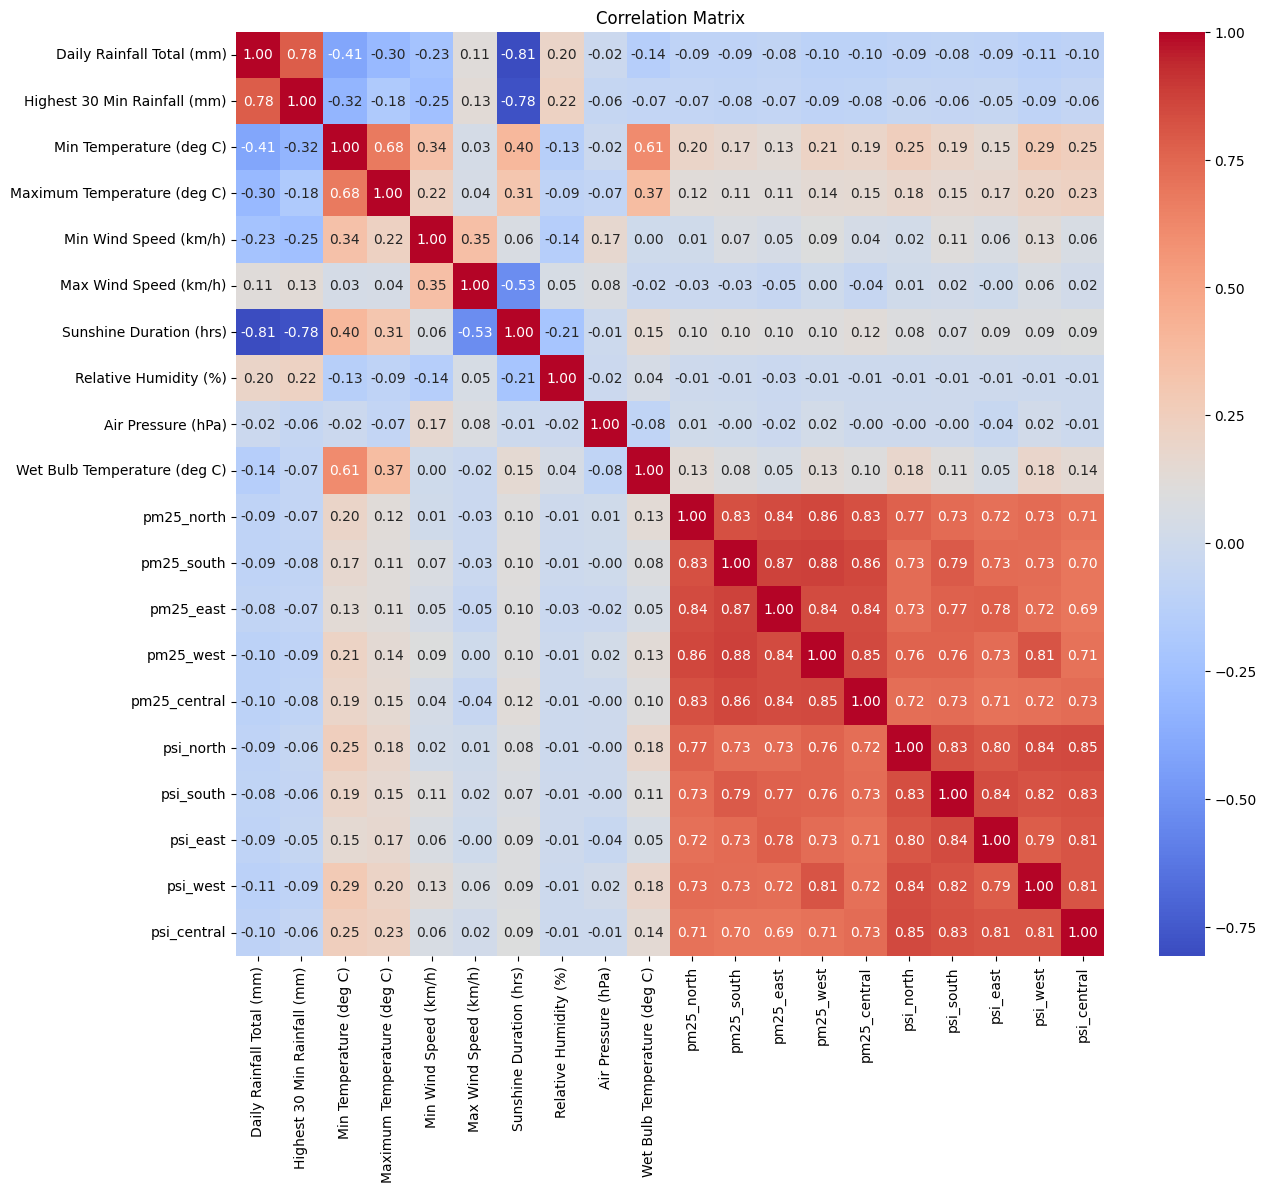

In [1260]:
numeric_data = merged_df.select_dtypes(include=['float64', 'int64'])
corr_matrix = numeric_data.corr()

# Correlation matrix visualization
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [1261]:
# Find features with correlation greater than the threshold

# Select the upper triangle of the correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

correlation_threshold = 0.8
to_drop = [column for column in upper.columns if any(upper[column] > correlation_threshold)]


print("\nHighly correlated features:")
for i in range (0, len(to_drop)):
    print(str(i + 1) + ". " + to_drop[i])


Highly correlated features:
1. pm25_south
2. pm25_east
3. pm25_west
4. pm25_central
5. psi_south
6. psi_east
7. psi_west
8. psi_central


1. A corr threshold of 0.8 nicely identifies the redundant features. 
2. I will remove the first 3 features because I think they are less relevant
3. For pm25 and psi, instead of removal, i will perform feature engineering later on to get the average, \
because for the label 'solar panel efficiency', it does not say which area it applies to. 

In [1262]:
merged_df.drop(columns=constant_cols, inplace=True)

#### remove unnecessary categorical features

In [1263]:
categorical_cols = merged_df.select_dtypes(include=['object']).columns

# Check unique values
for col in categorical_cols:
    unique_values = merged_df[col].nunique()
    print(f"Column '{col}' has {unique_values} unique values")

Column 'Dew Point Category' has 9 unique values
Column 'Wind Direction' has 8 unique values
Column 'Daily Solar Panel Efficiency' has 3 unique values


1. 'data_ref_x' and 'data_ref_y' is not relevant, I will remove it later on.
2. Check for unique values in 'dew point category' and 'wind direction'. 

In [1264]:
# checking 'wind direction'
unique_values = merged_df['Wind Direction'].unique()
print(unique_values)


['W' 'S' 'E' 'NE' 'NW' 'SE' 'SW' 'N']


In [1265]:
# checking 'dew point category'
unique_values = merged_df['Dew Point Category'].unique()
print(unique_values)

['Very High' 'Low' 'High' 'Moderate' 'Extreme' 'Very Low' 'Below Average'
 'Minimal' 'Normal']


I realized some values represent the same thing, but represented in different format\
so I am going to map them

In [1266]:
# Mapping dictionary for wind directions
wind_direction_map = {
    'N.': 'N',
    'W': 'W',
    'S': 'S',
    'E': 'E',
    'east': 'E',
    'NORTHEAST': 'NE',
    'NW': 'NW',
    'NE': 'NE',
    'SE': 'SE',
    'Southward': 'S',
    'W.': 'W',
    'southeast': 'SE',
    'SW': 'SW',
    'N': 'N',
    'Northward': 'N',
    'SOUTHEAST': 'SE',
    'northwest': 'NW',
    'west': 'W',
    'NORTH': 'N',
    'south': 'S',
    'NE.': 'NE',
    'SE.': 'SE',
    'NORTHWEST': 'NW',
    'northeast': 'NE',
    'SW.': 'SW',
    'north': 'N',
    'SOUTH': 'S',
    'E.': 'E',
    'S.': 'S',
    'NW.': 'NW',
    'WEST': 'W',
    'EAST': 'E'
}

# Apply the mapping to overwrite the existing 'Wind Direction' column
merged_df['Wind Direction'] = merged_df['Wind Direction'].map(wind_direction_map)
print(merged_df['Wind Direction'].unique())

['W' 'S' 'E' 'NE' 'NW' 'SE' 'SW' 'N']


In [1267]:
# Change dee point category to lower case
merged_df['Dew Point Category'] = merged_df['Dew Point Category'].str.lower()

# Mapping dictionary for 'dew point category'
label_map = {
    'vh': 'Very High',
    'very high': 'Very High',
    'low': 'Low',
    'vl': 'Very Low',
    'very low': 'Very Low',
    'high': 'High',
    'moderate': 'Moderate',
    'm': 'Moderate',
    'h': 'High',
    'extreme': 'Extreme',
    'minimal': 'Minimal',
    'normal': 'Normal',
    'high level': 'High',
    'below average': 'Below Average',
    'l': 'Low'  
}


merged_df['Dew Point Category'] = merged_df['Dew Point Category'].map(label_map).fillna('Unknown')
print(merged_df['Dew Point Category'].unique())


['Very High' 'Low' 'High' 'Moderate' 'Extreme' 'Very Low' 'Below Average'
 'Minimal' 'Normal']


dropping the features

In [1268]:
to_drop = ["data_ref_x", "data_ref_y",
           "Highest 60 Min Rainfall (mm)", "Highest 120 Min Rainfall (mm)", "Cloud Cover (%)"]

merged_df.drop(columns=to_drop, inplace=True)


KeyError: "['data_ref_x', 'data_ref_y', 'Highest 60 Min Rainfall (mm)', 'Highest 120 Min Rainfall (mm)', 'Cloud Cover (%)'] not found in axis"

In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3197 entries, 0 to 3196
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   date                          3197 non-null   datetime64[ns]
 1   Daily Rainfall Total (mm)     3197 non-null   float64       
 2   Highest 30 Min Rainfall (mm)  3197 non-null   float64       
 3   Min Temperature (deg C)       3197 non-null   float64       
 4   Maximum Temperature (deg C)   3197 non-null   float64       
 5   Min Wind Speed (km/h)         3197 non-null   float64       
 6   Max Wind Speed (km/h)         3197 non-null   float64       
 7   Sunshine Duration (hrs)       3197 non-null   float64       
 8   Relative Humidity (%)         3197 non-null   float64       
 9   Air Pressure (hPa)            3197 non-null   int64         
 10  Dew Point Category            3197 non-null   object        
 11  Wind Direction                

# Data Visualization

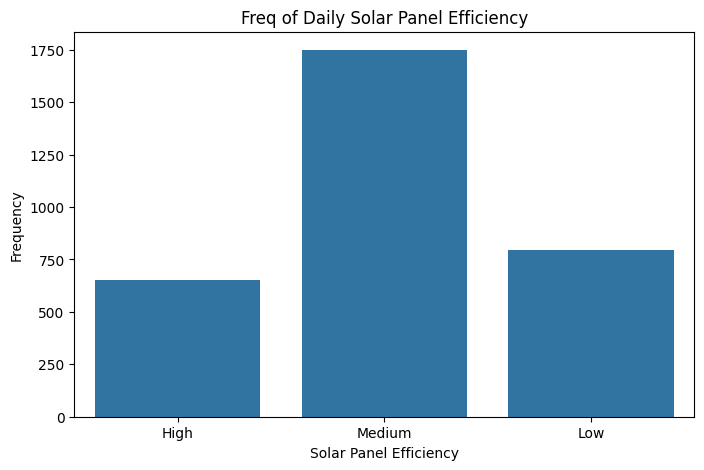

In [1242]:
# bar plot for Daily Solar Panel Efficiency
plt.figure(figsize=(8, 5))
sns.countplot(data=merged_df, x='Daily Solar Panel Efficiency')
plt.title('Freq of Daily Solar Panel Efficiency')
plt.xlabel('Solar Panel Efficiency')
plt.ylabel('Frequency')
plt.show()

There are more medium efficiency. Slightly more low than high efficiency 

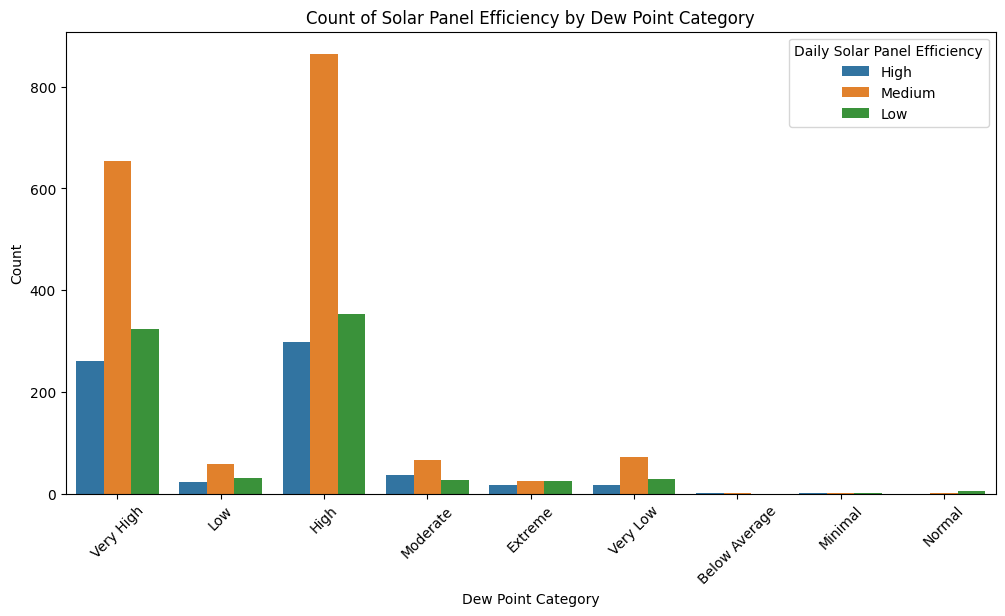

In [1243]:
# Count plot for Dew Point Category and Solar Panel Efficiency
plt.figure(figsize=(12, 6))
sns.countplot(x='Dew Point Category', hue='Daily Solar Panel Efficiency', data=merged_df)
plt.title('Count of Solar Panel Efficiency by Dew Point Category')
plt.xlabel('Dew Point Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


High and Very High dew point categories have a significant number of medium efficiency counts. \
This might indicate that higher dew points has some influence on maintaining medium efficiency levels.

Categories with fewer observations (like Minimal, Normal, Below Average) \
might not provide sufficient data to draw strong conclusion, I can consider combine them together later.

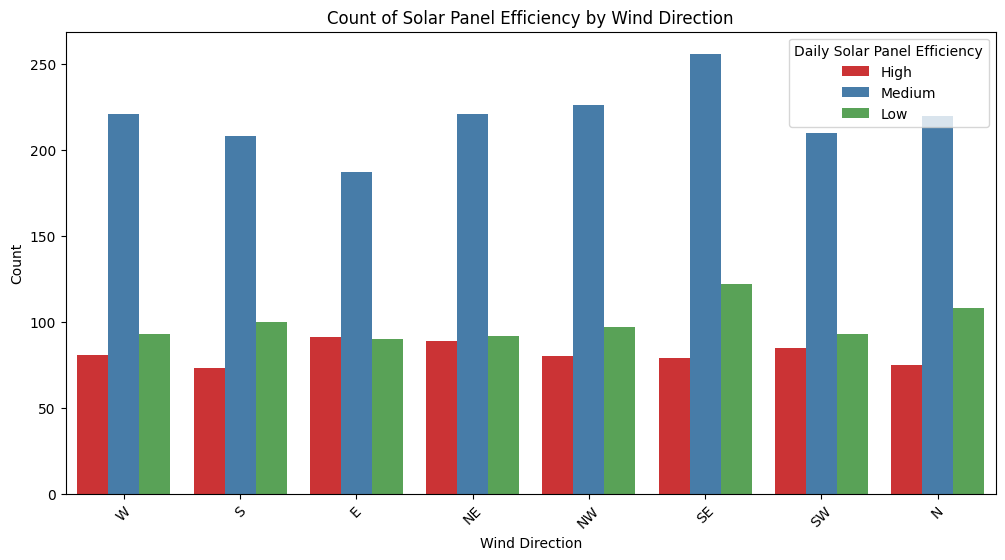

In [1244]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count plot for Wind Direction and Solar Panel Efficiency
plt.figure(figsize=(12, 6))
sns.countplot(x='Wind Direction', hue='Daily Solar Panel Efficiency', data=merged_df, palette='Set1')
plt.title('Count of Solar Panel Efficiency by Wind Direction')
plt.xlabel('Wind Direction')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

The overall trend suggests that medium efficiency is the norm for most wind directions, \
while low efficiency is more common than high efficiency. 

This might imply that wind direction is a less significant feature. 

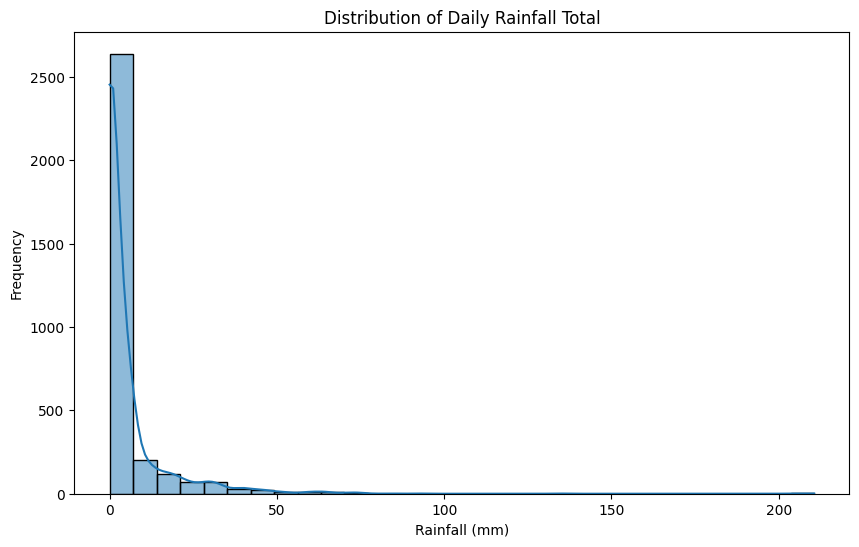

In [1245]:
# Example of histogram for Daily Rainfall Total
plt.figure(figsize=(10, 6))
sns.histplot(data=merged_df, x='Daily Rainfall Total (mm)', bins=30, kde=True)
plt.title('Distribution of Daily Rainfall Total')
plt.xlabel('Rainfall (mm)')
plt.ylabel('Frequency')
plt.show()

There are more number of days where it does not rain

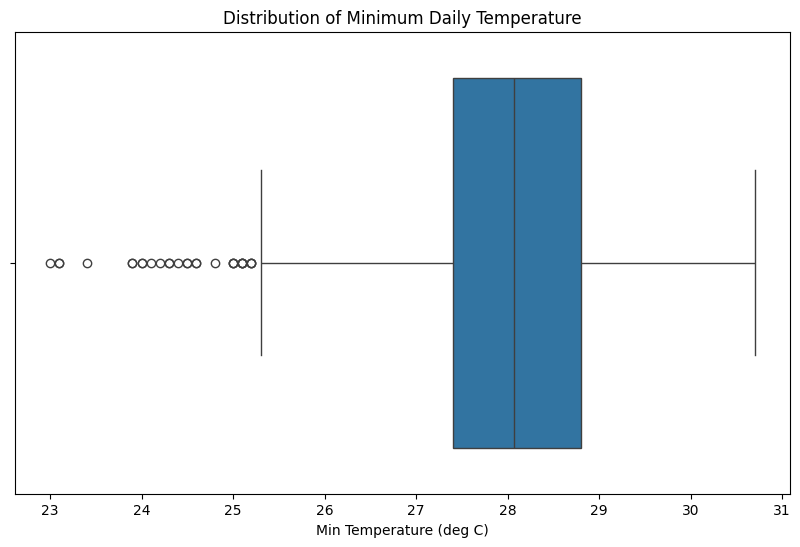

In [1246]:
# box plot of min temp
plt.figure(figsize=(10, 6))
sns.boxplot(x='Min Temperature (deg C)', data=merged_df)
plt.title('Distribution of Minimum Daily Temperature')
plt.xlabel('Min Temperature (deg C)')
plt.show()


Median of minimum temperature is at 28 degree celsius.  Lower minimum temperature might mean that the efficiency is lower. 

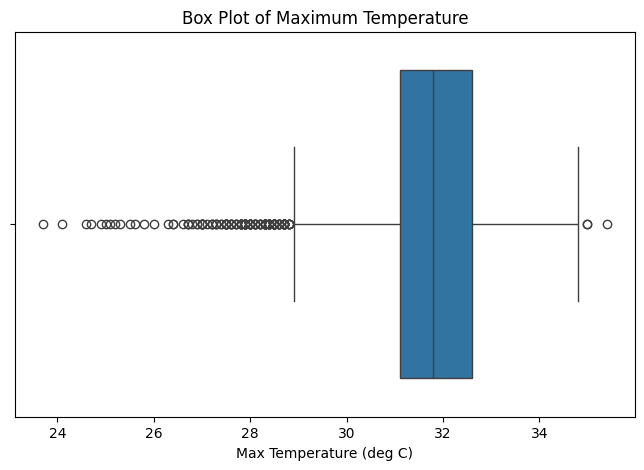

In [1247]:
# box plot for Maximum Temperature
plt.figure(figsize=(8, 5))
sns.boxplot(data=merged_df, x='Maximum Temperature (deg C)')
plt.title('Box Plot of Maximum Temperature')
plt.xlabel('Max Temperature (deg C)')
plt.show()

There are some outliers where max temperature is below 28 degrees. 

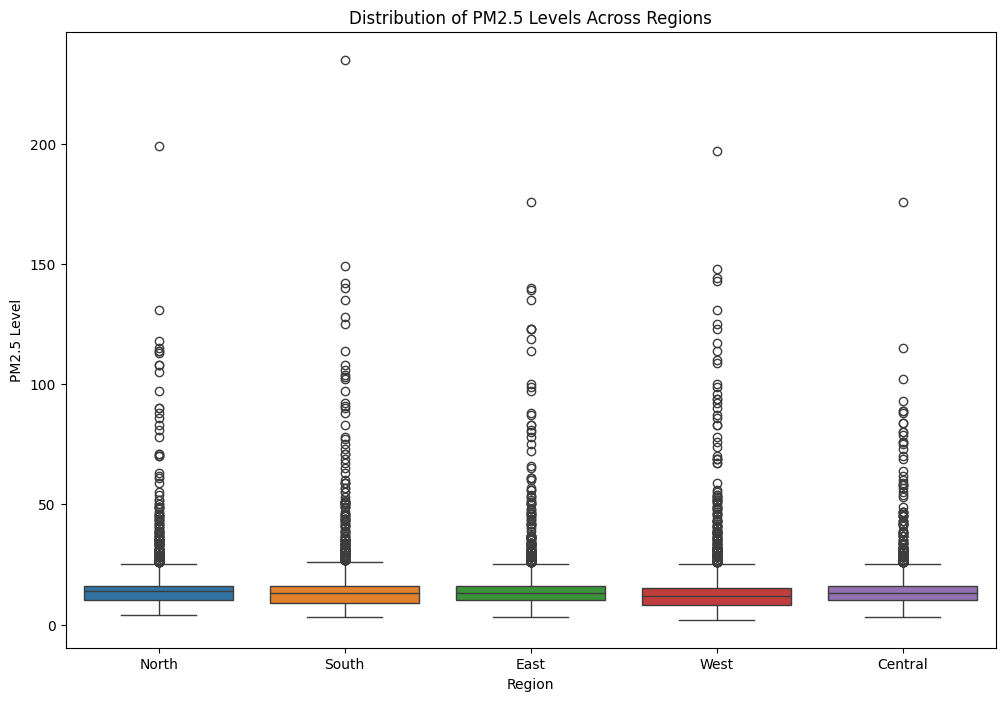

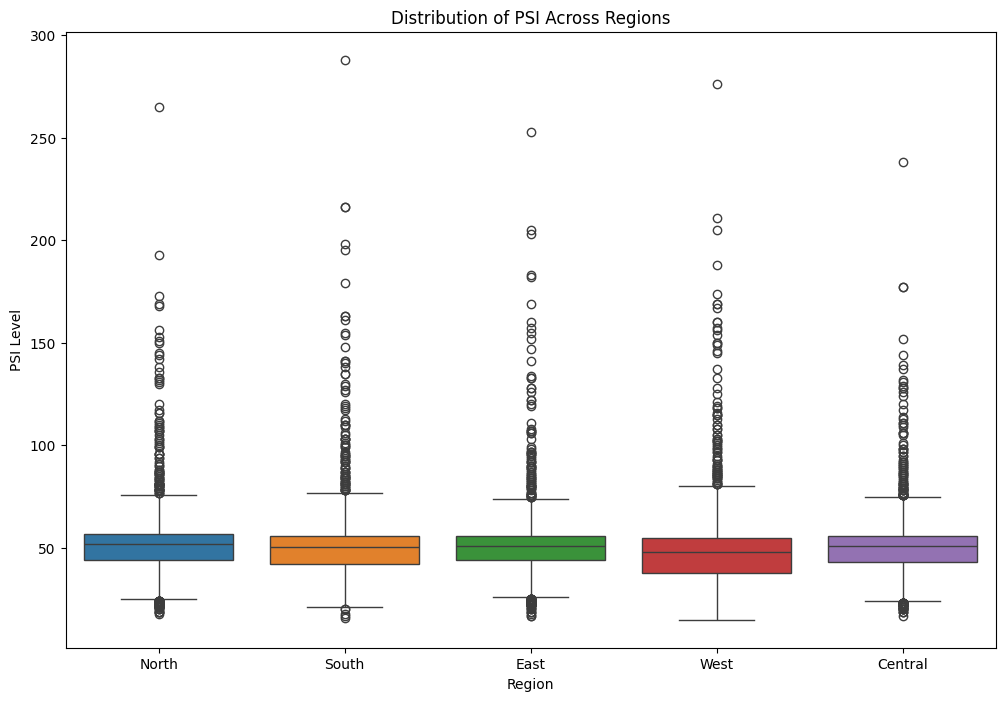

In [1248]:
# box plot of PM2.5 and PSI across all regions 
plt.figure(figsize=(12, 8))
sns.boxplot(data=merged_df[['pm25_north', 'pm25_south', 'pm25_east', 'pm25_west', 'pm25_central']])
plt.title('Distribution of PM2.5 Levels Across Regions')
plt.ylabel('PM2.5 Level')
plt.xlabel('Region')
plt.xticks(ticks=[0, 1, 2, 3, 4], labels=['North', 'South', 'East', 'West', 'Central'])
plt.show()

plt.figure(figsize=(12, 8))
sns.boxplot(data=merged_df[['psi_north', 'psi_south', 'psi_east', 'psi_west', 'psi_central']])
plt.title('Distribution of PSI Across Regions')
plt.ylabel('PSI Level')
plt.xlabel('Region')
plt.xticks(ticks=[0, 1, 2, 3, 4], labels=['North', 'South', 'East', 'West', 'Central'])
plt.show()


PM2.5 are relatively stable across all regions. \
PSI are relatively stable across all regions.
I will perform feature engineering in task 2.

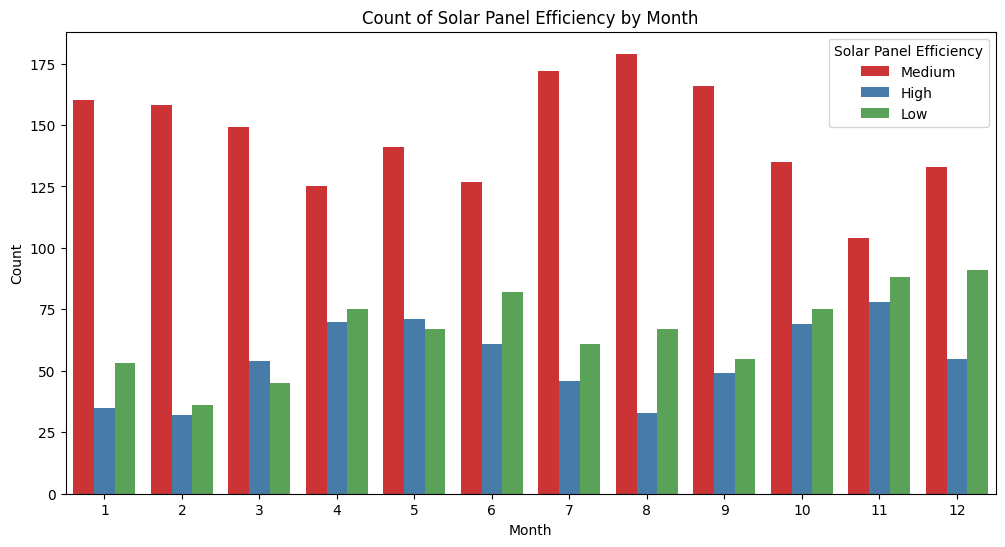

In [1249]:
# Extract the month from the date column
merged_df['Month'] = merged_df['date'].dt.month

# Create a count plot for Month and Solar Panel Efficiency
plt.figure(figsize=(12, 6))
sns.countplot(x='Month', hue='Daily Solar Panel Efficiency', data=merged_df, palette='Set1')
plt.title('Count of Solar Panel Efficiency by Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.legend(title='Solar Panel Efficiency')
plt.show()

- Medium efficiency is the most common throughout the year.
- High efficiency is less frequent but shows slight increases in certain months.
- Low efficiency peaks in April, June, July, November, and December.

This indicating potentially challenging conditions for solar panel performance during different months.

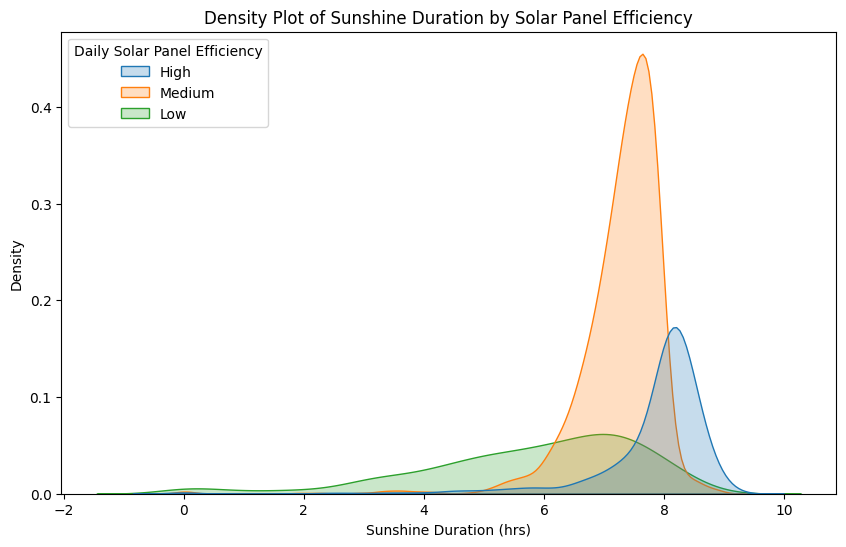

In [1250]:
# KDE plot for Sunshine Duration by Solar Panel Efficiency
plt.figure(figsize=(10, 6))
sns.kdeplot(data=merged_df, x='Sunshine Duration (hrs)', hue='Daily Solar Panel Efficiency', fill=True)
plt.title('Density Plot of Sunshine Duration by Solar Panel Efficiency')
plt.xlabel('Sunshine Duration (hrs)')
plt.ylabel('Density')
plt.show()

Higher sunshine duration tends to favor medium (7-8 hours) and high efficiency (8 hours), whereas lower \
sunshine duration is associated with low efficiency (6-7 hours). This aligns with the expectation \
that more sunlight generally improves solar panel efficiency.

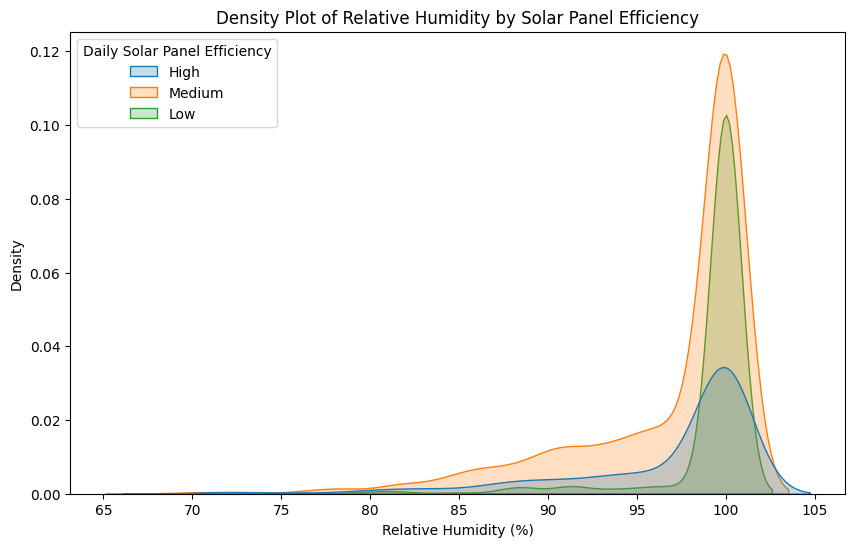

In [1251]:
# density plot for relative humidity by Solar Panel Efficiency
plt.figure(figsize=(10, 6))
sns.kdeplot(data=merged_df, x='Relative Humidity (%)', hue='Daily Solar Panel Efficiency', fill=True)
plt.title('Density Plot of Relative Humidity by Solar Panel Efficiency')
plt.xlabel('Relative Humidity (%)')
plt.ylabel('Density')
plt.show()

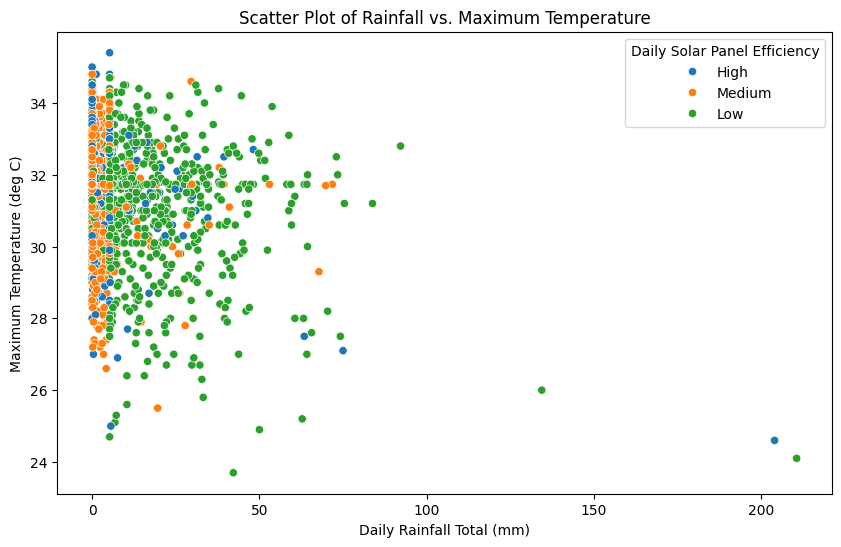

In [1252]:
# scatter plot for Rainfall vs. Maximum Temperature
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Daily Rainfall Total (mm)', y='Maximum Temperature (deg C)', hue='Daily Solar Panel Efficiency', data=merged_df)
plt.title('Scatter Plot of Rainfall vs. Maximum Temperature')
plt.xlabel('Daily Rainfall Total (mm)')
plt.ylabel('Maximum Temperature (deg C)')
plt.show()


1. Temperature vs daily rainfall total:\
Maximum temperature seems to have a wide range irrespective of the amount of daily rainfall, \
indicating that temperature does not strongly correlate with rainfall in this dataset.\
There are a few outliers with high rainfall values (around 50 mm and 200 mm), but these are less common.

2. Solar Panel Efficiency: 

High and medium Efficiency (Blue) : Generally more towards the left (lower rainfall), \
especially when rainfall is zero. A few high-efficiency points are \
associated with high rainfall, but these are rare.

Low Efficiency (Green): When daily rainfall increases, it is more likely to be low efficiency. 

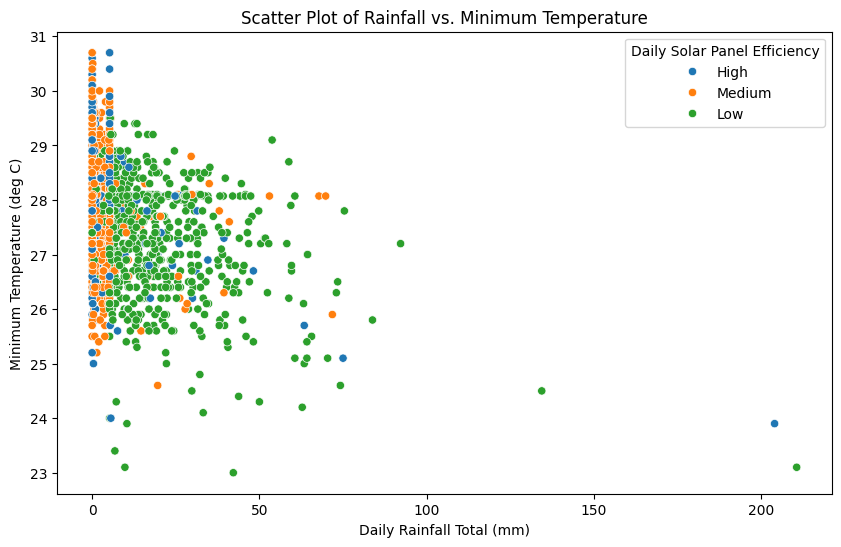

In [1253]:
# scatter plot for Rainfall vs. Minimum Temperature
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Daily Rainfall Total (mm)', y='Min Temperature (deg C)', hue='Daily Solar Panel Efficiency', data=merged_df)
plt.title('Scatter Plot of Rainfall vs. Minimum Temperature')
plt.xlabel('Daily Rainfall Total (mm)')
plt.ylabel('Minimum Temperature (deg C)')
plt.show()

Similar to maximum temperature, but minimum temperature ranges from 23 - 31 deg c.

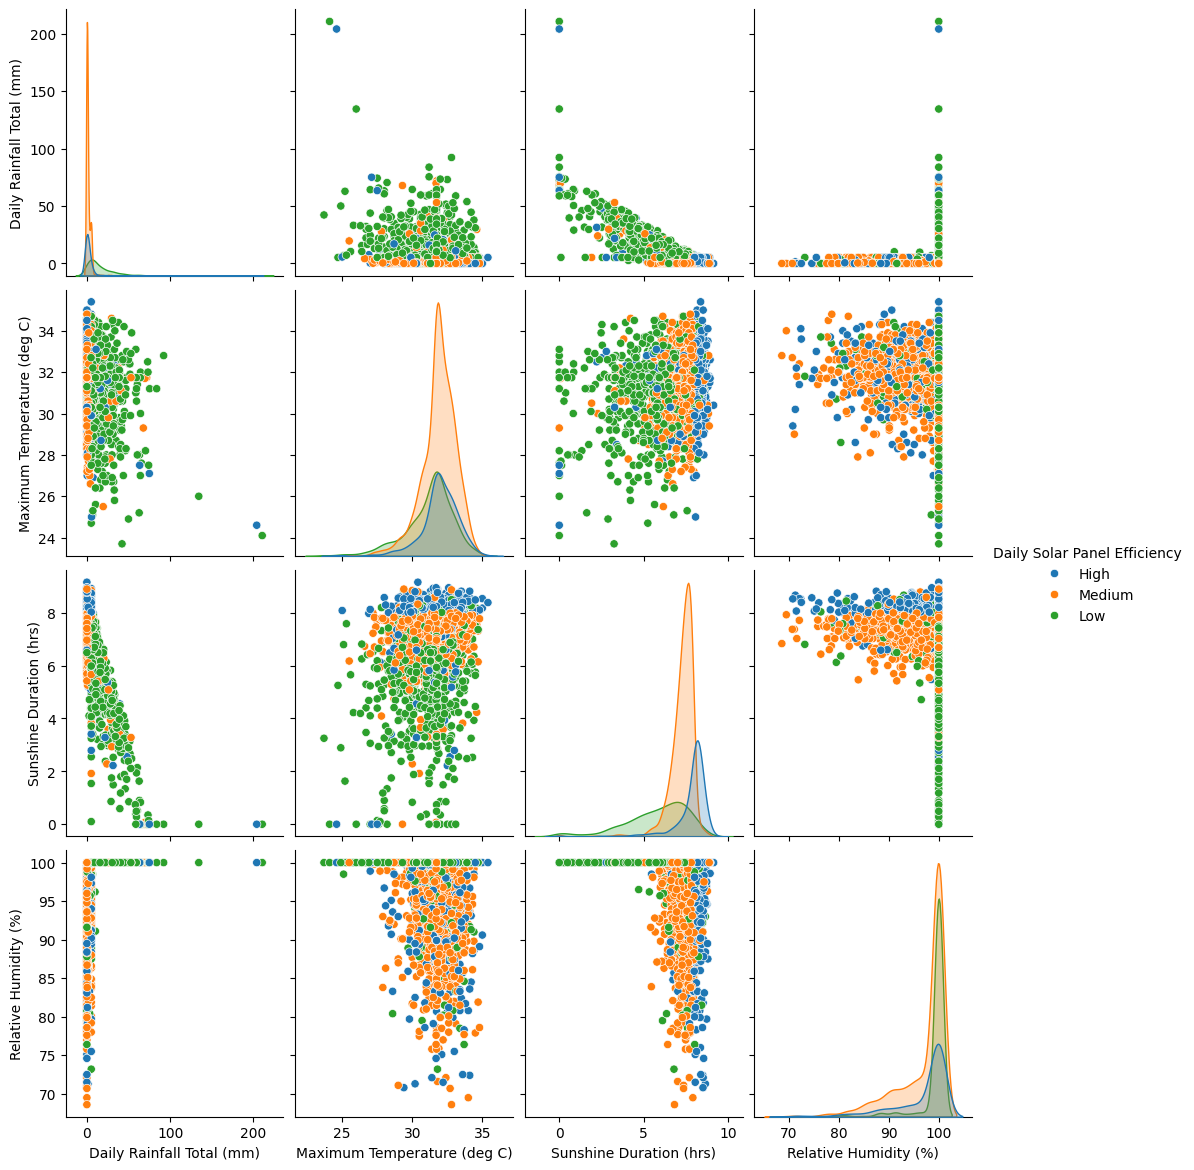

In [1254]:
# Select the columns to include in the scatterplot matrix
columns_to_plot = [
    'Daily Rainfall Total (mm)', 
    'Maximum Temperature (deg C)', 
    'Sunshine Duration (hrs)', 
    'Relative Humidity (%)'
]

# Create a subset of the DataFrame with the selected columns and the label
df_subset = merged_df[columns_to_plot + ['Daily Solar Panel Efficiency']]

# Create the pairplot with hue based on the label
g = sns.pairplot(df_subset, hue='Daily Solar Panel Efficiency', diag_kind='kde')

# Adjust the plot size
g.fig.set_size_inches(12, 12)

# Show the plot
plt.show()

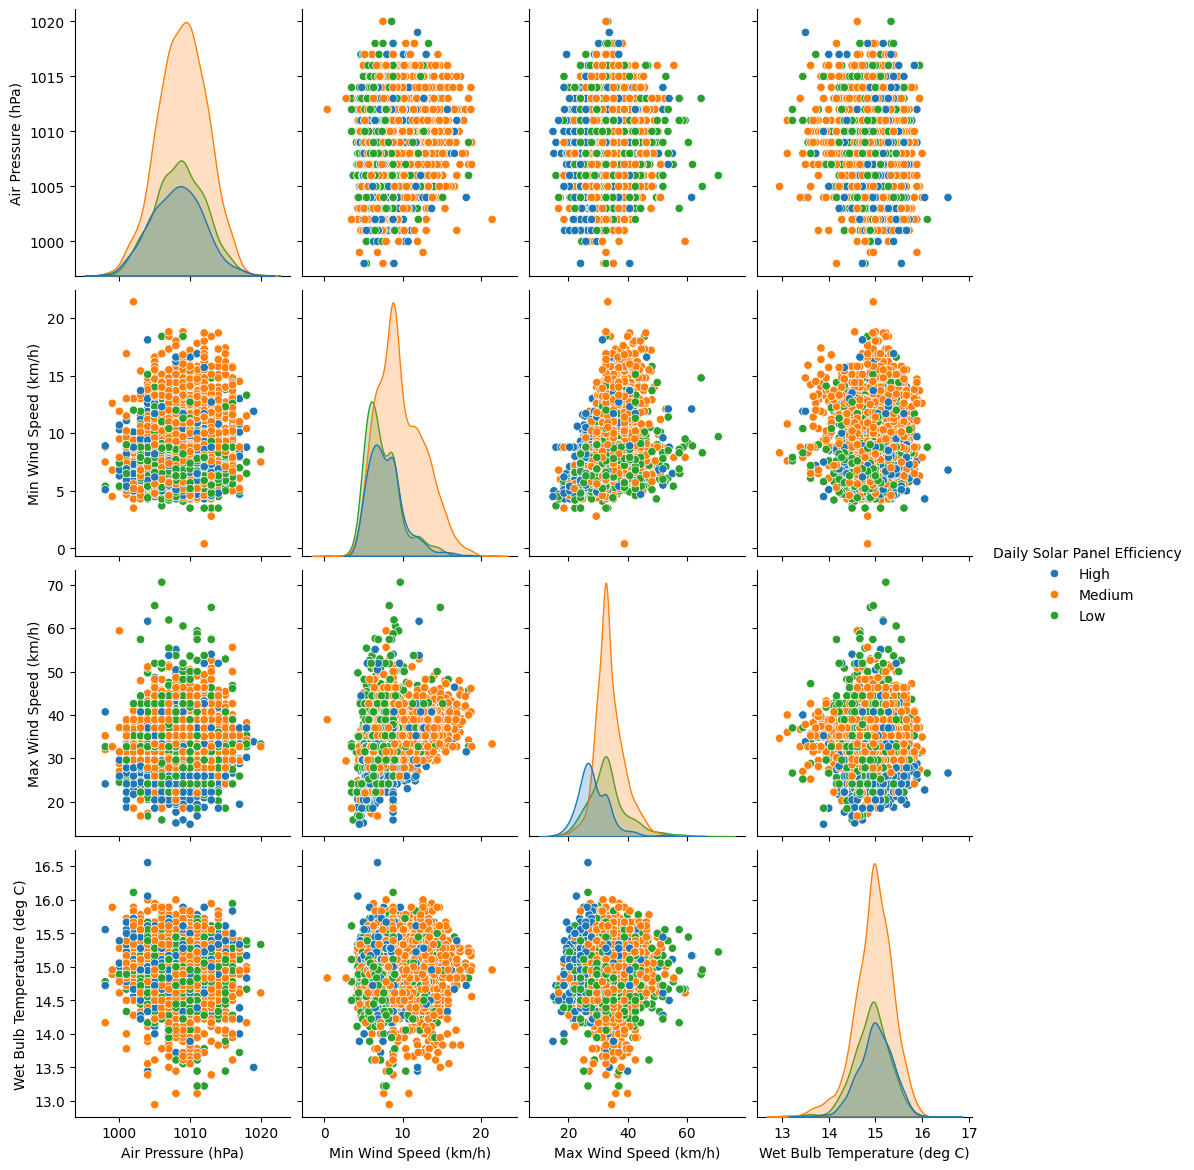

In [1259]:
# Select the columns to include in the scatterplot matrix
columns_to_plot = [
    'Air Pressure (hPa)', 
    'Min Wind Speed (km/h)', 
    'Max Wind Speed (km/h)', 
    'Wet Bulb Temperature (deg C)'
]

# Create a subset of the DataFrame with the selected columns and the label
df_subset = merged_df[columns_to_plot + ['Daily Solar Panel Efficiency']]

# Create the pairplot with hue based on the label
g = sns.pairplot(df_subset, hue='Daily Solar Panel Efficiency', diag_kind='kde')

# Adjust the plot size
g.fig.set_size_inches(12, 12)

# Show the plot
plt.show()

- We can see that the number of 